<a href="https://colab.research.google.com/github/britneh/DS-Unit-2-Applied-Modeling/blob/master/Britne_H_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/britneh/DS-Unit-2-Applied-Modeling/master/data/Britne_H%20CPSData.csv'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import shap

In [0]:
diversity = pd.read_csv(DATA_PATH)

In [7]:
diversity = diversity[diversity['Age'] >= 18]
diversity
diversity.isnull().sum()

PeopleInHousehold         0
Region                    0
State                     0
MetroAreaCode         26475
Age                       0
Married                   0
Sex                       0
Education                 0
Race                      0
Hispanic                  0
CountryOfBirthCode        0
Citizenship               0
EmploymentStatus        450
Industry              35317
dtype: int64

In [8]:
diversity = diversity.fillna('Unemployed')
diversity.isnull().sum()

PeopleInHousehold     0
Region                0
State                 0
MetroAreaCode         0
Age                   0
Married               0
Sex                   0
Education             0
Race                  0
Hispanic              0
CountryOfBirthCode    0
Citizenship           0
EmploymentStatus      0
Industry              0
dtype: int64

In [9]:
diversity.nunique()

PeopleInHousehold      15
Region                  4
State                  51
MetroAreaCode         265
Age                    64
Married                 5
Sex                     2
Education               8
Race                    6
Hispanic                2
CountryOfBirthCode    161
Citizenship             3
EmploymentStatus        5
Industry               15
dtype: int64

In [0]:
# Simplify industry so that the least are in one group 'other'
otherindustries = ['Other services', 'Agriculture, forestry, fishing, and hunting', 'Mining', 'Armed forces']
#Replace the specified industries to Other
diversity.loc[diversity['Industry'].isin(otherindustries), 'Industry']= 'Other'

In [11]:
#Look at updated dataset 
diversity

,PeopleInHousehold,Region,State,MetroAreaCode,Age,Married,Sex,Education,Race,Hispanic,CountryOfBirthCode,Citizenship,EmploymentStatus,Industry
0,1,South,Alabama,26620,85,Widowed,Female,Associate degree,White,0,57,"Citizen, Native",Retired,Unemployed
1,3,South,Alabama,13820,21,Never Married,Male,High school,Black,0,57,"Citizen, Native",Unemployed,Professional and business services
2,3,South,Alabama,13820,37,Never Married,Female,High school,Black,0,57,"Citizen, Native",Disabled,Unemployed
3,3,South,Alabama,13820,18,Never Married,Male,No high school diploma,Black,0,57,"Citizen, Native",Not in Labor Force,Unemployed
4,3,South,Alabama,26620,52,Widowed,Female,Associate degree,White,0,57,"Citizen, Native",Employed,Professional and business services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131293,2,West,Wyoming,Unemployed,27,Never Married,Male,High school,White,0,57,"Citizen, Native",Unemployed,Professional and business services
131294,5,West,Wyoming,Unemployed,39,Divorced,Female,Associate degree,White,0,57,"Citizen, Native",Not in Labor Force,Unemployed
131298,5,West,Wyoming,Unemployed,37,Divorced,Male,High school,White,0,57,"Citizen, Native",Employed,Other
131299,3,West,Wyoming,Unemployed,58,Married,Male,Bachelor's degree,White,0,57,"Citizen, Native",Employed,Financial


In [71]:
diversity['Industry'].value_counts()

Unemployed                            35317
Educational and health services       14939
Trade                                  8751
Professional and business services     7473
Manufacturing                          6770
Leisure and hospitality                5925
Other                                  5017
Construction                           4367
Financial                              4339
Transportation and utilities           3256
Public administration                  3181
Information                            1319
Name: Industry, dtype: int64

In [12]:
y= diversity['Industry']


12

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(diversity, stratify=diversity['Industry'], random_state=42)
train.shape, test.shape

((75490, 14), (25164, 14))

In [27]:
train, val = train_test_split(train, train_size=0.50, test_size=0.50, 
                              stratify=train['Industry'], random_state=42)
train.shape, val.shape

((30196, 14), (30196, 14))

In [0]:
target = 'Industry'
features = train.columns.drop([target, 'MetroAreaCode', 'CountryOfBirthCode', 'State', 'PeopleInHousehold'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [29]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (30196, 9)
y_train shape (30196,)
X_val shape (30196, 9)
y_val shape (30196,)
X_test shape (25164, 9)
y_test shape (25164,)


# PDP

In [65]:
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

X = diversity[features]
y = diversity[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)


model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
#Try to encode y
#y_encoded = encoder.fit_transform(y)

In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'Sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)


gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
#print('Gradient Boosting R^2', r2_score(y_val, y_pred))

In [0]:
#Do plot
#Does it need numeric 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Age'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

In [80]:
type(isolated)

list

In [0]:
!

Text(0.5, 0, 'Cheese')

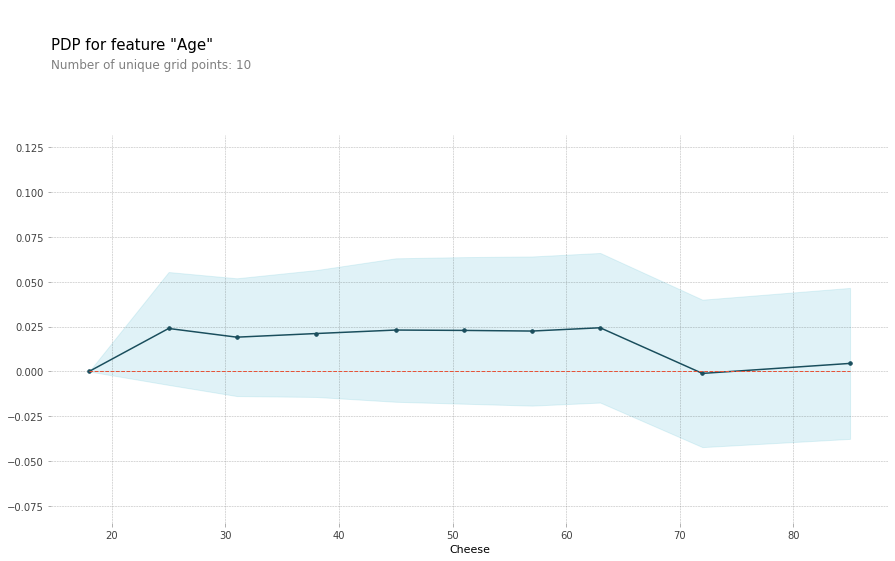

In [86]:
pdp_plot(isolated, feature, which_classes= [1]);
plt.xlabel('Cheese')

# Shapely

In [90]:
#  IMPORTANT FOR YOUR SPRINT CHALLENGE

from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba, 'ovr')) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:


ValueError: ignored

In [88]:
row = X_test.iloc[[3094]]
row

# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

AssertionError: ignored